In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Setup
Here we define some output paths.

In [2]:
images = Path('datasets/sacre_coeur')
outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

10 mapping images


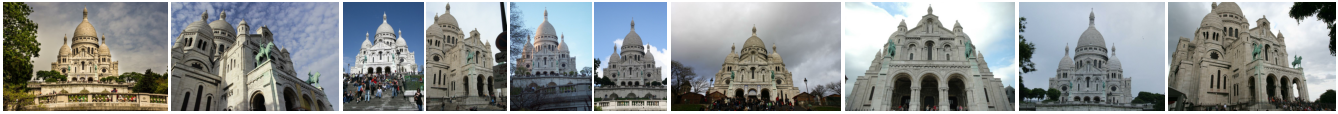

In [3]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [4]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/07/19 16:35:16 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
[2023/07/19 16:35:18 hloc INFO] Finished exporting features.
[2023/07/19 16:35:18 hloc INFO] Found 45 pairs.
[2023/07/19 16:35:18 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


Loaded LightGlue model


  0%|          | 0/45 [00:00<?, ?it/s]

[2023/07/19 16:35:20 hloc INFO] Finished exporting matches.


The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [6]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

[2023/07/19 16:37:41 hloc WARNING] The database already exists, deleting it.
[2023/07/19 16:37:41 hloc INFO] Creating an empty database...


[2023/07/19 16:37:41 hloc INFO] Importing images into the database...
[2023/07/19 16:37:41 hloc INFO] Importing features into the database...


  0%|          | 0/10 [00:00<?, ?it/s]

[2023/07/19 16:37:41 hloc INFO] Importing matches into the database...


  0%|          | 0/45 [00:00<?, ?it/s]

[2023/07/19 16:37:41 hloc INFO] Performing geometric verification of the matches...
[2023/07/19 16:37:41 hloc INFO] Running 3D reconstruction...
[2023/07/19 16:37:49 hloc INFO] Reconstructed 1 model(s).
[2023/07/19 16:37:49 hloc INFO] Largest model is #0 with 10 images.
[2023/07/19 16:37:49 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 10
	num_cameras = 10
	num_points3D = 5907
	num_observations = 31653
	mean_track_length = 5.35856
	mean_observations_per_image = 3165.3
	mean_reprojection_error = 0.842772
	num_input_images = 10


We also visualize which keypoints were triangulated into the 3D model.

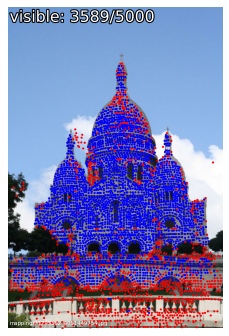

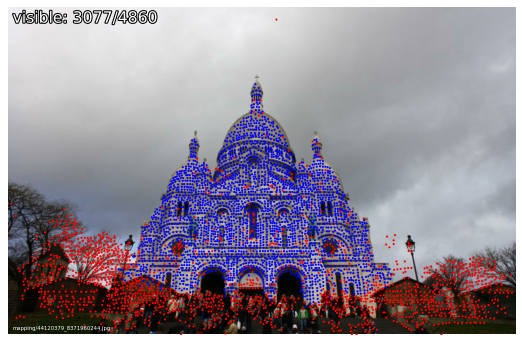

In [7]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

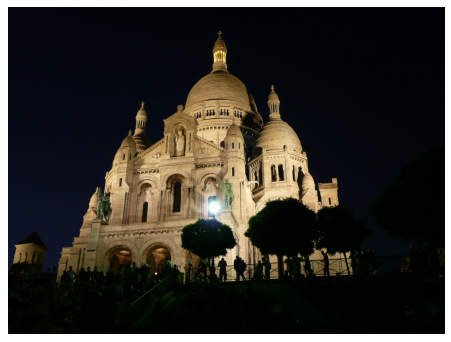

In [8]:
url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/5/59/Basilique_du_Sacr%C3%A9-C%C5%93ur_%285430392880%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
query = 'query/night.jpg'
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively.

In [9]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2023/07/19 21:12:38 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

found 3156/4665 inlier correspondences.


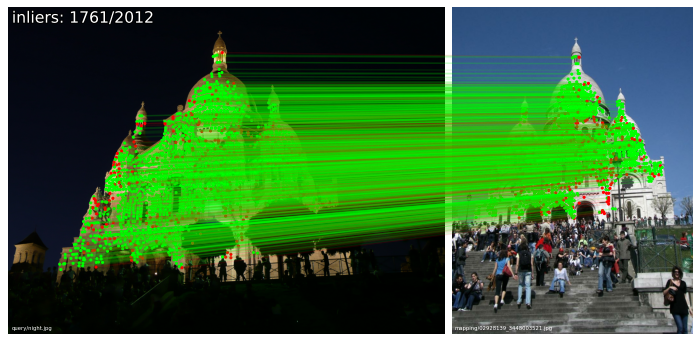

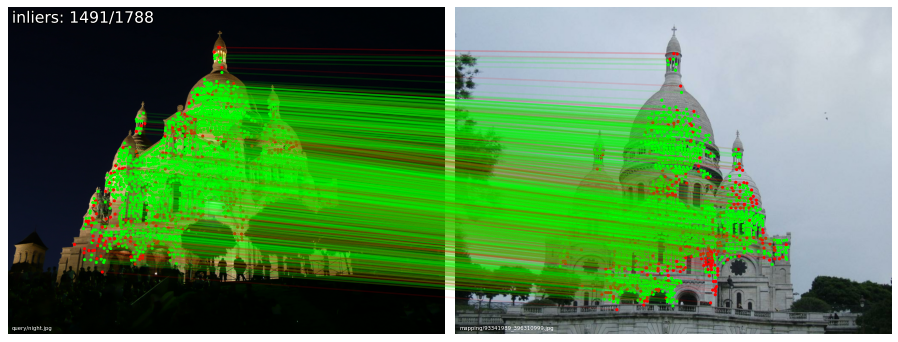

In [9]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [ ]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()